In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import GetOldTweets3 as got

<img src="./images/musk.jpeg" align = 'left' alt="tingo" width="300"/>

# Get the Tweets
Tweet code converted the cell to markdown so that we don't have to keep loading it.

tweetCriteria = got.manager.TweetCriteria().setUsername("elonmusk").setMaxTweets(60000)
tweet = got.manager.TweetManager.getTweets(tweetCriteria)

elon = []
for i in range(len(tweet)):
    dict = {}
    dict['date'] = tweet[i].date
    dict['tweet'] = tweet[i].text
    
    elon.append(dict)

elon_musk = pd.DataFrame(elon)

elon_musk['date'] = elon_musk['date'].astype('str')
elon_musk['date'] = elon_musk['date'].str[:10]
elon_musk['date'] = pd.to_datetime(elon_musk['date'])

elon_musk.to_csv('elon.csv', index = False)

In [2]:
# reading in the saved tweet data
elon_musk = pd.read_csv('elon.csv')
elon_musk['date'] = pd.to_datetime(elon_musk['date'], format='%Y-%m-%d')
elon_musk.dropna(inplace = True)

# Get the Stock Prices

In [3]:
# header for the API call
headers = {
    'Content-Type': 'application/json'
}

In [4]:
# setting up the parameters variables for the Tiingo API
start = str(pd.to_datetime(datetime.now() + timedelta(weeks = -15), format='%Y-%m-%d'))[:10] # setting up date range
stop = str(pd.to_datetime(datetime.today(), format='%Y-%m-%d'))[:10] # using [:10] to subset string
date_range = pd.date_range(start = start, end = stop) # date range

In [5]:
# grabbing the stock price information for the Vandguard S&P 500 ETF
tickers = 'tsla'
startDate = '2010-01-01'
endDate = stop
token = 'API Key'
url = str(f"https://api.tiingo.com/tiingo/daily/{tickers}/prices?&startDate={startDate}&endDate={endDate}&token={token}")

# this is an example of how to filter news story by ticker
requestResponse = requests.get(url,
                               headers=headers)

In [6]:
test_price = pd.DataFrame(requestResponse.json()) # requesting data

In [7]:
test_price['date'] = test_price['date'].str[:10]  # cleaning up data setting up proper date format
test_price['date'] = pd.to_datetime(test_price['date'], format='%Y-%m-%d')
test_price.set_index('date', inplace = True)

In [8]:
test_price.head() # data check

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18766300,23.89,25.0000,17.54,19.00,18766300,0.0,1.0
2010-06-30,23.83,30.4192,23.30,25.79,17187100,23.83,30.4192,23.30,25.79,17187100,0.0,1.0
2010-07-01,21.96,25.9200,20.27,25.00,8218800,21.96,25.9200,20.27,25.00,8218800,0.0,1.0
2010-07-02,19.20,23.1000,18.71,23.00,5139800,19.20,23.1000,18.71,23.00,5139800,0.0,1.0
2010-07-06,16.11,20.0000,15.83,20.00,6866900,16.11,20.0000,15.83,20.00,6866900,0.0,1.0


In [9]:
# creating target variable
test_price['vol'] = (abs((test_price['open']-test_price['close'])/test_price['open']) > 0.03).astype(int) 
test_price[['vol']].head() # data check

,vol
date,
2010-06-29,1
2010-06-30,1
2010-07-01,1
2010-07-02,1
2010-07-06,1


# Merging DataFrames

In [10]:
df = pd.merge(elon_musk, # merging two data frames to create a data frame that has news items associated with whether or not the
              test_price, # S&P 500 went up or down that day
              how = 'inner', 
              left_on = 'date',
              right_on = 'date')[['date', 'tweet', 'vol']]
df['vol'].value_counts() 

0    4724
1    1180
Name: vol, dtype: int64

In [11]:
df.shape

(5904, 3)

In [12]:
# generating the value to rebalance the class
diff = df['vol'].value_counts()[0]-df['vol'].value_counts()[1]

# Modeling

In [13]:
# import modling packages
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score,\
                            accuracy_score, precision_score, confusion_matrix, roc_auc_score, classification_report

In [14]:
# bootstrapping
gain = df[df['vol'] == 1]

bootstrap = gain.sample(n=diff, 
                           replace=True,
                           random_state=42
                           )
df = pd.concat([df, bootstrap])

In [15]:
# checking for null values
df.isnull().sum()

date     0
tweet    0
vol      0
dtype: int64

In [16]:
# setting up X and y variable
X = df['tweet']
y = df['vol']

In [17]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=29)

In [18]:
# pipeline
pipe = Pipeline([ 
    ('cvec', TfidfVectorizer(stop_words = 'english' )),
    ('rf', (RandomForestClassifier()))  # setting up pipeline
])

In [19]:
# setting up parameters for grid search
pipe_params = {
    'cvec__max_features' : [4000], # pipe parameters
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,2), (1,3)],
    #'lr__C' : [1, 10, 100],
    #'lr__max_iter' : [1000]
}

In [20]:
# grid search
gs = GridSearchCV(pipe,
                  pipe_params, # setting up grid search
                  cv = 5,
                  n_jobs = 11)

In [21]:
# fitting the model
gs.fit(X_train, y_train); # fitting the model

In [22]:
# getting the scores
print(f'Train score is {gs.score(X_train, y_train)}') # scoring
print(f'Test score is {gs.score(X_test, y_test)}')    # nice looks like there's no overfitting
print(f'Score diff is {gs.score(X_test, y_test) - gs.score(X_train, y_train)}')

Train score is 0.9312796208530806
Test score is 0.8479794740218088
Score diff is -0.08330014683127174


In [23]:
# what's the best parameters
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [24]:
# generating confusion matrix
predict = gs.predict(X_test)
confusion_matrix(y_test, predict)

pd.DataFrame(confusion_matrix(y_test, predict), # confusion matrix
             columns = ['predicted true', 'predicted false'],
             index = ['actual true', 'actual false'])

,predicted true,predicted false
actual true,1322,206
actual false,268,1322


In [25]:
# prep to generating the ROC score
predict = gs.predict(X_test)

In [26]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)] # taken from the lesson classificaiton metrics ii
pred_df = pd.DataFrame({'true_values': y_test,  # because I honestly forgot how to do this all
                        'pred_probs':pred_proba})

In [27]:
# not too bad
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9285350604234581

In [28]:
# classification report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1528
           1       0.87      0.83      0.85      1590

    accuracy                           0.85      3118
   macro avg       0.85      0.85      0.85      3118
weighted avg       0.85      0.85      0.85      3118



## Estimate Most Important Words

In [29]:
# setting up best estimator
cvec = gs.best_estimator_.named_steps['cvec']
fi = gs.best_estimator_.named_steps['rf'].feature_importances_

In [30]:
# prep for sparse dataframe
X_train_raw = cvec.fit_transform(X_train)

In [31]:
# sparse dataframe
X_train_sp = pd.DataFrame.sparse.from_spmatrix(X_train_raw, columns=cvec.get_feature_names())

In [32]:
# features dataframe
features_df = pd.DataFrame(fi, X_train_sp.columns, columns = ['importance'])

In [33]:
# plotting
barplot = features_df.sort_values(by = 'importance', ascending = False).head(10)

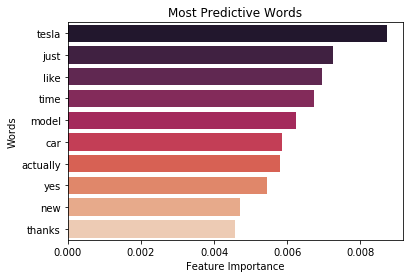

In [34]:
# most predicted words
sns.barplot(y = barplot.index, x = barplot['importance'], orient = 'h', palette="rocket")
plt.xlabel('Feature Importance')
plt.ylabel('Words')
plt.title('Most Predictive Words');